# Learning Discrete-Time Estimation with Transformers

How well does the transformer perform in-context learning on a stateful task. 

In [3]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

myDevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from kalman_filter import *
from helpers import *
from plotting import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 250 # how long to simulate the trajectory

ModuleNotFoundError: No module named 'torch'

### Define the System Parameters

In [26]:
task_name = 'so2' # Choose from 'so2', 'motion', 'so3', 'accel', 'smd'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]()

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

In [27]:
num_traj = 20 # How many to test on
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

Trajectory shape (250, 2)
Measured shape (250, 2)


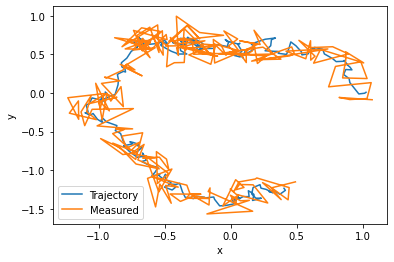

In [28]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

## -1. ZOH Baseline 
Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [29]:
zoh_rec = np.zeros(shape=(num_traj, T, state_dim))


err_sm = np.linalg.norm(zoh_rec - meas)**2
print("Error is", err_sm / num_traj / T)

Error is 1.2408687130458562


## 0. Optimization Based Approach using known A, B, C to get best possible fit

This is the baseline for BERT

In [30]:
err_opt = 0
ls_rec = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    print("Solving problem", i)
    ls_rec[i] = optimal_traj(A, B, C, Q, R, meas[i], x0, u_seq[i])

err_opt += np.linalg.norm(ls_rec - traj)**2 / T / num_traj
    
print("Average Squared Error", err_opt)

Solving problem 0
Solving problem 1
Solving problem 2
Solving problem 3
Solving problem 4
Solving problem 5
Solving problem 6
Solving problem 7
Solving problem 8
Solving problem 9
Solving problem 10
Solving problem 11
Solving problem 12
Solving problem 13
Solving problem 14
Solving problem 15
Solving problem 16
Solving problem 17
Solving problem 18
Solving problem 19
Average Squared Error 0.002996316827371738


## 1. Kalman Filtering using known A, B, C to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [10]:
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kfiltered[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr = np.linalg.norm(kfiltered - traj)**2 / num_traj / T
    
print("Average Squared Error:", err_fltr)

Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Converged in 18 iterations
Average Squared Error: 0.005163852780911296


Trajectory shape (250, 2)
Measured shape (250, 2)
Filtered shape (250, 2)


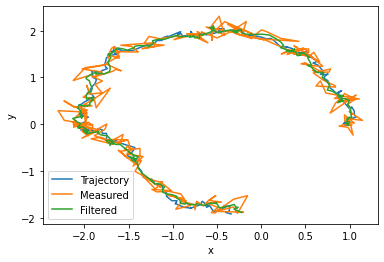

In [11]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered[0]})

### 1b. Kalman Filter with pure steady state gains

In [12]:
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    kfiltered_ss[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr_ss = np.linalg.norm(kfiltered_ss - traj)**2 / num_traj / T

print("Average Squared Error", err_fltr_ss)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Average Squared Error 0.005175639203992821


In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered_ss[0]})

### 1c. Kalman Smoothing with Reverse Kalman Filter

In [ ]:
err_kf_smoothed = 0

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0) # Forward KF
    fltr_fwd = kinematics_forward.simulate(meas[i], u_seq[i])
    
    kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=traj[i][-1]) # Backward KF
    fltr_bkwd = np.flip(kinematics_backward.simulate(np.flip(meas[i], axis=0), np.flip(u_seq[i], axis=0)), axis=0)
    
    # Kalman Smoothed (Avg forward and backward)
    smooth_states = (fltr_fwd + fltr_bkwd) / 2
    err_kf_smoothed += np.linalg.norm(smooth_states - traj[i])**2
    
print("Average Squared Error", err_kf_smoothed / num_traj / T)

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

Note - The System Identification as implemented currently requires the state dimension to match the obs dimension. so2 and so3

In [ ]:
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)

    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_filtered[i, t] = kinematics.state
    
err_id_fltr = np.linalg.norm(id_filtered[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': id_filtered[0]})

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [ ]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_filtered_simulated[i, t] = kinematics.simulate(meas[i, :t], u_seq[i, :t])[-1]

    
err_id_fltr_sim = np.linalg.norm(id_filtered_simulated[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr_sim)

In [ ]:
plot({"Trajectory:": traj[0], "ID + Filtered": id_filtered_simulated[0]})

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

Note that the learning the Kalman Filter can get roughly the same performance as the optimal Kalman Filter if trained for long enough. 

Iteration 1000 : Loss 4.866683145348748
Iteration 2000 : Loss 4.0461684318439906
Iteration 3000 : Loss 3.7737609843350812
Iteration 4000 : Loss 3.672052725718685
Iteration 5000 : Loss 3.62764802413937
Iteration 6000 : Loss 3.5949592609522947
Iteration 7000 : Loss 3.562976871402565
Iteration 8000 : Loss 3.540970226779276
Iteration 9000 : Loss 3.5271167646831993
Iteration 10000 : Loss 3.5149447773715727
Iteration 11000 : Loss 3.5071907780079026
Iteration 12000 : Loss 3.5032868977637284
Iteration 13000 : Loss 3.4993907829251483
Iteration 14000 : Loss 3.4971682814420757


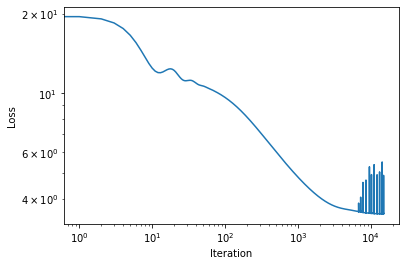

Average Squared Error 0.008566220245337148


In [20]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = 0
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_learned_kf / T) #num_traj_test / T)

[[ 1.00036497  0.06233351]
 [ 0.98561801  0.03162948]
 [ 0.97202367  0.0378817 ]
 [ 0.95993173  0.00363182]
 [ 0.9466909   0.0180825 ]
 [ 0.94571635  0.00962738]
 [ 0.94709762  0.03179008]
 [ 0.95831393  0.1178951 ]
 [ 0.95389312  0.15315806]
 [ 0.94398799  0.16919046]
 [ 0.93746535  0.20020486]
 [ 0.93540546  0.22481294]
 [ 0.93685613  0.27487269]
 [ 0.93184464  0.31495837]
 [ 0.93392765  0.33229273]
 [ 0.94453693  0.34320361]
 [ 0.94607877  0.42452652]
 [ 0.95386896  0.52126911]
 [ 0.94879713  0.51795897]
 [ 0.93378925  0.54962545]
 [ 0.91023545  0.56439307]
 [ 0.86574148  0.49055764]
 [ 0.87440237  0.51666328]
 [ 0.86746648  0.5030915 ]
 [ 0.85754638  0.54007138]
 [ 0.85425923  0.59485905]
 [ 0.83972666  0.6439486 ]
 [ 0.83434511  0.67063821]
 [ 0.81402591  0.67188514]
 [ 0.80869452  0.69175857]
 [ 0.79160972  0.69051837]
 [ 0.7903914   0.77495329]
 [ 0.7829364   0.83982411]
 [ 0.77173166  0.91075226]
 [ 0.75978676  0.99104996]
 [ 0.75634987  1.05348133]
 [ 0.74223828  1.10080655]
 

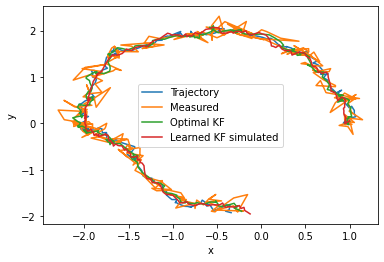

Error between traj and meas 0.019984243951819157
Average Squared Error of filtered 0.00862345449033436
Error between filtered and meas 0.024322543253420176


In [23]:
print(learned_kfs_simulated[0])
plot({'Trajectory': traj[0], "Measured":meas[0], "Optimal KF": kfiltered[0], "Learned KF simulated": learned_kfs_simulated[0]})

print('Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of filtered', np.linalg.norm(learned_kfs_simulated[0] - traj[0])**2 / T)
print('Error between filtered and meas', np.linalg.norm(learned_kfs_simulated[0] - meas[0])**2 / T)

In [24]:
#The cell below is useful to compare the LearnedKF parameters to true parameters of the Kalman Filter
learned_kf = learned_kfs[0]
true_kf = KFilter(A, B, C, Q, R, state=x0)
true_kf.run_till_ss()
print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
print("Aprime learned is", learned_kf.Aprime)
print("Bprime true is", B)
print("Bprime learned is", learned_kf.Bprime)
print("Gprime true is", A @ true_kf.K)
print("Gprime learned is", learned_kf.Gprime)
print("Cprime true is", C)
print("Cprime learned is", learned_kf.Cprime)

Converged in 0 iterations
Aprime true is [[ 0.7297356  -0.01273758]
 [ 0.01273758  0.7297356 ]]
Aprime learned is tensor([[ 0.9410, -0.0891],
        [-0.0676,  0.8406]], requires_grad=True)
Bprime true is [[0]
 [1]]
Bprime learned is tensor([[0.0636],
        [1.0696]], requires_grad=True)
Gprime true is [[ 0.2701121  -0.00471482]
 [ 0.00471482  0.2701121 ]]
Gprime learned is tensor([[0.0564, 0.0715],
        [0.0844, 0.1604]], requires_grad=True)
Cprime true is [[1. 0.]
 [0. 1.]]
Cprime learned is tensor([[1., 0.],
        [0., 1.]])


# Transformer-based techniques to learn the dynamics and filter the position

In [ ]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 64 # use 64-dimensional embedding for now
batch_size = 32

### Test data

In [ ]:
target_sequences_test = torch.from_numpy(meas).to(myDevice)
input_sequences_test = torch.from_numpy(u_seq).to(myDevice)
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj).to(myDevice)

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [ ]:
num_iterations = 2000

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=obs_dim,
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(myDevice)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)
    

    # Cast to PyTorch tensors
    target_sequences_train = torch.from_numpy(meas_batch).to(myDevice) # trying to hit noisy data
    input_sequences_train = torch.from_numpy(u_batch).to(myDevice)
    transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
    
    # Run through the GPT model
    decoder_output = gpt_model(transformer_input_train, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

    # Compute Loss and Backpropagate
    loss = loss_func(decoder_output, target_sequences_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    curr_loss = loss.item()
    losses.append(curr_loss)
    
    print('Iteration', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale('log')
plt.show()

In [ ]:
torch.save(gpt_model.state_dict(), 'gpt_checkpoint.pt')

### Test the GPT-style Model

In [ ]:
gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=obs_dim,
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(myDevice)
gpt_model.load_state_dict(torch.load('gpt_checkpoint.pt'))
gpt_model.eval()

gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
i = 0 # index to visualize (0 through 19)

filtered = gpt_transformer_sim.detach().cpu().numpy()

plot({"Trajectory": traj[i], "Measured": meas[i], "Filtered by GPT": filtered[i], "Optimal KF": kfiltered[i]})

print('Average Squared Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of filtered vs traj', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)

## BERT-style: Transformer Encoder only, predict true trajectory from Noisy Measurements

In [ ]:
num_iterations = 500

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, # trying to hit the actual state (not the observation)
                n_layers=6, n_heads=4, d_filter=256, dropout=None).to(myDevice)

optimizer = torch.optim.Adam(bert_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_iterations):
    
    # Generate new training data each iteration
    u_batch = 0.05 * (rng.random(size=(batch_size, T, input_dim))*2 - 1)
    traj_batch, meas_batch = generate_traj(batch_size, T, A, B, C, Q, R, x0, u_batch, state_dim, input_dim, obs_dim)

    # Cast to PyTorch tensors
    meas_sequences_train = torch.from_numpy(meas_batch).to(myDevice)
    input_sequences_train = torch.from_numpy(u_batch).to(myDevice)
    transformer_input_train = torch.cat((meas_sequences_train, input_sequences_train), dim=2) # shape [batch_size, seq_len, (obs_dim+input_dim)]
    true_positions_train = torch.from_numpy(traj_batch).to(myDevice)

    # Run through the model
    encoder_output = bert_model(transformer_input_train, encoder_mask=None)    
    
    # Loss 
    loss = loss_func(encoder_output, true_positions_train) # Trying to hit true positions
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    curr_loss = loss.item()
    losses.append(curr_loss)
        
    print('Iteration', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
torch.save(bert_model.state_dict(), 'bert_checkpoint.pt')

### Test the BERT-style Model

In [ ]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
i = 0

filtered = bert_transformer_sim.detach().cpu().numpy()

plot({"Trajectory": traj[i], "Measured":meas[i], "Filtered":filtered[i], "Optimal KF":kfiltered[i]})

print('Error between traj and meas', np.linalg.norm(traj - meas)**2 / num_traj / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj)**2 / num_traj / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas)**2 / num_traj / T)
